In [21]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder

import random

from sklearn.metrics import classification_report, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns=None
pd.options.mode.chained_assignment = None

In [2]:
triggers_actions = pd.read_csv(r'C:\Users\User\triggers\before_logreg.csv',index_col=0).reset_index(drop =  True)

In [3]:
def encode_columns(df, columns):
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_data = encoder.fit_transform(df[columns])
    
    # Создаем DataFrame с новыми названиями столбцов
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns))
    encoded_df.index = df.index  # сохраняем индекс для правильного объединения
    
    # Объединяем закодированные данные с исходным DataFrame и удаляем оригинальные столбцы
    df = pd.concat([df.drop(columns, axis=1), encoded_df], axis=1)
    return df

In [4]:

# Пример использования:
triggers_actions = encode_columns(triggers_actions, ['type', 'last_successful_type'])

In [5]:
triggers_actions['trigger'] = triggers_actions['trigger'].astype('category')

In [6]:
triggers_actions.head()

,guid,date,trigger,action_date,result,time_since_last_action,triggers_since_last_action,type_2,type_3,last_successful_type_1.0,last_successful_type_2.0,last_successful_type_3.0
0,0187808e-d664-cc1d-403d-b93ac1365ee8,2024-05-20 15:30:28,59,0,0,0.000000,1,0.0,0.0,0.0,0.0,0.0
1,0187808e-d664-cc1d-403d-b93ac1365ee8,2024-05-23 07:04:59,59,0,0,2.648970,2,0.0,0.0,0.0,0.0,0.0
2,0187808e-e508-2486-7385-30069e7c0a7f,2024-05-21 18:45:45,12,0,0,0.000000,1,0.0,0.0,0.0,0.0,0.0
3,0187808e-e508-2486-7385-30069e7c0a7f,2024-05-21 18:45:46,27,0,0,0.000012,2,0.0,0.0,0.0,0.0,0.0
4,0187808e-e508-2486-7385-30069e7c0a7f,2024-05-21 18:45:46,168,0,0,0.000012,3,0.0,0.0,0.0,0.0,0.0


In [7]:
X = triggers_actions.drop(columns = ['guid','date','result','action_date'])
y_succes = triggers_actions['result']  # таргет для взаимодействия

# Разделение данных на train/test с фиксацией индексов
X_train, X_test, y_train_success, y_test_success = train_test_split(X, y_succes, test_size=0.3, random_state=42)

In [8]:
# Сохраняем индексы, которые попали в train/test
train_indices = X_train.index
test_indices = X_test.index

In [9]:
### модели 
# модель для взаимодействия 
logreg_success = LogisticRegression(class_weight='balanced',multi_class='ovr')

logreg_success.fit(X_train, y_train_success)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: 

LogisticRegression(class_weight='balanced', multi_class='ovr')

In [10]:

# получаем вероятности для каждого из классов
probs = logreg_success.predict_proba(X_test)

In [11]:

# добавляем вероятности для каждого класса в датафрейм
triggers_actions.loc[test_indices,'prob_no_interaction'] = probs[:, 0]  # вероятность для класса 0 (нет взаимодействия)
triggers_actions.loc[test_indices,'prob_success'] = probs[:, 1]         # вероятность для класса 1 (успех)
triggers_actions.loc[test_indices,'prob_unsuccessful'] = probs[:, 2]    # вероятность для класса -1 (неуспех)


In [12]:
triggers_actions.head(10)

,guid,date,trigger,action_date,result,time_since_last_action,triggers_since_last_action,type_2,type_3,last_successful_type_1.0,last_successful_type_2.0,last_successful_type_3.0,prob_no_interaction,prob_success,prob_unsuccessful
0,0187808e-d664-cc1d-403d-b93ac1365ee8,2024-05-20 15:30:28,59,0,0,0.000000,1,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,0187808e-d664-cc1d-403d-b93ac1365ee8,2024-05-23 07:04:59,59,0,0,2.648970,2,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,0187808e-e508-2486-7385-30069e7c0a7f,2024-05-21 18:45:45,12,0,0,0.000000,1,0.0,0.0,0.0,0.0,0.0,0.269665,0.484533,0.245803
3,0187808e-e508-2486-7385-30069e7c0a7f,2024-05-21 18:45:46,27,0,0,0.000012,2,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,0187808e-e508-2486-7385-30069e7c0a7f,2024-05-21 18:45:46,168,0,0,0.000012,3,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
5,0187808e-e508-2486-7385-30069e7c0a7f,2024-05-21 18:45:46,133,0,0,0.000012,4,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
6,0187808e-e508-2486-7385-30069e7c0a7f,2024-05-21 18:45:48,188,0,0,0.000035,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
7,0187808e-e508-2486-7385-30069e7c0a7f,2024-05-21 18:45:51,6,0,0,0.000069,6,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
8,0187808e-e508-2486-7385-30069e7c0a7f,2024-05-21 18:45:51,243,0,0,0.000069,7,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
9,0187808e-e508-2486-7385-30069e7c0a7f,2024-05-21 18:45:52,155,0,0,0.000081,8,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


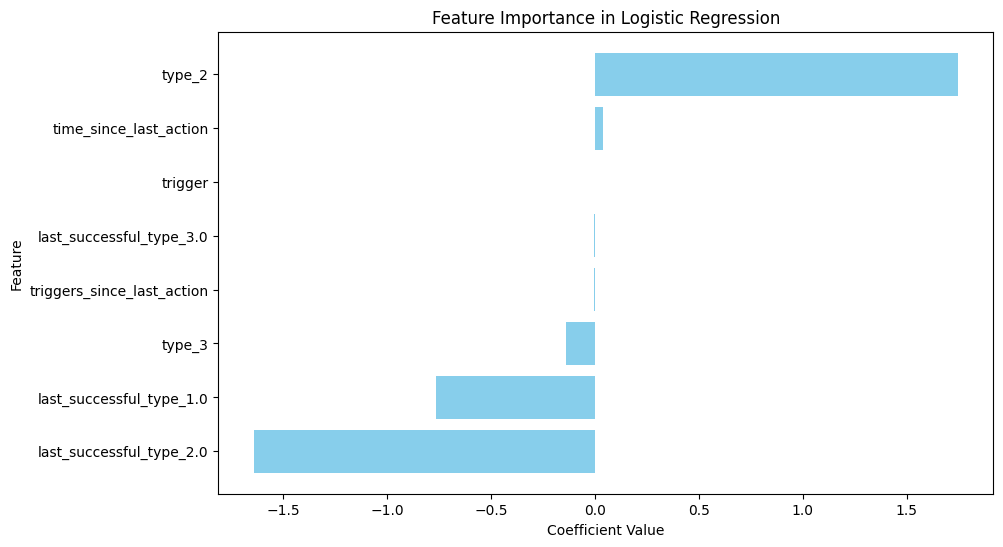

In [ ]:
# получаем коэффициенты модели
feature_importance = logreg_success.coef_[0]

# создаем DataFrame для наглядности
feature_names = X_train.columns  # названия признаков из обучающего набора
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# сортируем признаки по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# визуализация
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis() 
plt.show()

In [17]:
after_logreg_success = triggers_actions.dropna()[triggers_actions['result'] == 1]
after_logreg_fail = triggers_actions.dropna()[triggers_actions['result'] == -1]

C:\Users\User\AppData\Local\Temp\ipykernel_14480\2557694679.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after_logreg_success = triggers_actions.dropna()[triggers_actions['result'] == 1]
C:\Users\User\AppData\Local\Temp\ipykernel_14480\2557694679.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after_logreg_fail = triggers_actions.dropna()[triggers_actions['result'] == -1]


In [19]:
after_logreg_success.head()

,guid,date,trigger,action_date,result,time_since_last_action,triggers_since_last_action,type_2,type_3,last_successful_type_1.0,last_successful_type_2.0,last_successful_type_3.0,prob_no_interaction,prob_success,prob_unsuccessful
6662,018783be-25da-710a-36a7-2d50f5a61395,2024-05-03 12:40:29,103,1,1,0.000220,5,0.0,0.0,0.0,0.0,0.0,0.267460,0.485660,0.246880
7359,018783be-b7c8-5d48-9eaa-629bcd01d575,2024-05-11 09:02:15,1773,1,1,0.000000,1,1.0,0.0,0.0,0.0,0.0,0.444153,0.120223,0.435624
8573,018783bf-0c68-7d31-fe70-6199813488a1,2024-05-12 06:11:21,1835,1,1,10.978252,267,1.0,0.0,0.0,0.0,0.0,0.356946,0.213950,0.429103
11437,018783bf-fee2-0048-ea84-62e50fb17a64,2024-05-07 06:12:50,2065,1,1,5.997813,26,1.0,0.0,0.0,0.0,0.0,0.450300,0.107445,0.442254
14197,018783c1-a3e2-c205-b94c-80d0d87c8cc7,2024-05-18 08:04:09,1793,1,1,15.985093,5,1.0,0.0,0.0,0.0,0.0,0.475374,0.074306,0.450320


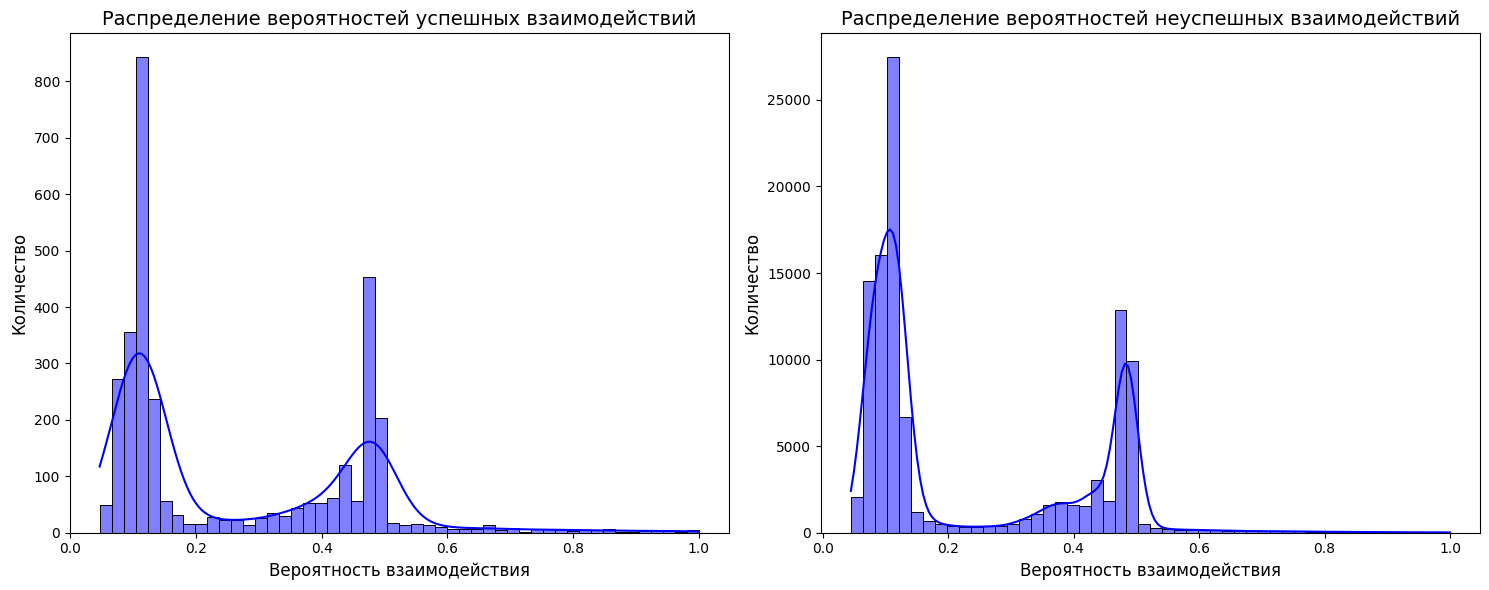

In [20]:
# создаем фигуру и две оси рядом
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# первый график - для успешных взаимодействий
sns.histplot(after_logreg_success['prob_success'], bins=50, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Распределение вероятностей успешных взаимодействий', fontsize=14)
axes[0].set_xlabel('Вероятность взаимодействия', fontsize=12)
axes[0].set_ylabel('Количество', fontsize=12)

# второй график - для неуспешных взаимодействий
sns.histplot(after_logreg_fail['prob_success'], bins=50, kde=True, color='blue', ax=axes[1])
axes[1].set_title('Распределение вероятностей неуспешных взаимодействий', fontsize=14)
axes[1].set_xlabel('Вероятность взаимодействия', fontsize=12)
axes[1].set_ylabel('Количество', fontsize=12)

# отображаем оба графика
plt.tight_layout()
plt.show()

### пробуем деревья

In [23]:
# создаем и обучаем модель
tree_clf = DecisionTreeClassifier(random_state=0, class_weight='balanced')
tree_clf.fit(X_train, y_train_success)


DecisionTreeClassifier(class_weight='balanced', random_state=0)

In [24]:

# предсказания на тестовом наборе
y_pred = tree_clf.predict(X_test)

# выводим отчет по качеству классификации
print(classification_report(y_test_success, y_pred))

              precision    recall  f1-score   support

          -1       0.07      0.32      0.12    110258
           0       0.99      0.94      0.97  11028782
           1       0.00      0.15      0.00      3278

    accuracy                           0.94  11142318
   macro avg       0.36      0.47      0.36  11142318
weighted avg       0.98      0.94      0.96  11142318



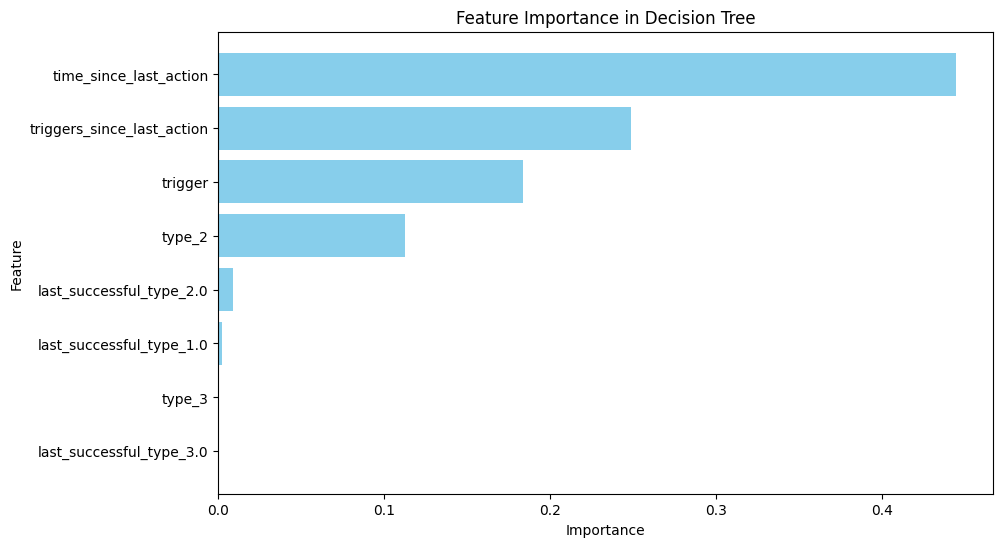

In [25]:
# извлечение важности признаков
feature_importances = tree_clf.feature_importances_

# создаем DataFrame для удобства отображения
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# сортируем признаки по важности
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# визуализируем важность признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree')
plt.gca().invert_yaxis()
plt.show()